The code cointains a lot of repetitions, it should be improved using functions

In [169]:
#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from tqdm import tqdm
import time
import pickle


In [170]:
#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Function

In [171]:
def get_pn_df(df, grp):

    # find the user_location with the most appearences
    a = df[grp].value_counts()
    #print("Most appearences :")
    #display(a)

    #keep only the ones with more than 5 appearences
    a = a[a > 5]
    #display(a)

    #remove all the lines of df_short that are not in a
    df = df[df[grp].isin(a.index)]
    
    # group neg by grp
    df_neg = df.groupby([grp])['neg'].apply(list).reset_index()
    df_neg['mean'] = df_neg['neg'].apply(np.mean)
    df_neg['median'] = df_neg['neg'].apply(np.median)
    #display(df_neg)

    # group pos by user_location
    df_pos = df.groupby([grp])['pos'].apply(list).reset_index()
    df_pos['mean'] = df_pos['pos'].apply(np.mean)
    df_pos['median'] = df_pos['pos'].apply(np.median)
    #display(df_pos)

    
    return df_neg, df_pos

In [172]:
def set_map():
    # Load shapefiles
    world = gpd.read_file('../data/shapefiles/world-administrative-boundaries.zip')
    states = gpd.read_file('../data/shapefiles/georef-united-states-of-america-state-millesime.zip')
    uk = gpd.read_file('../data/shapefiles/infuse_ctry_2011_clipped.zip')

    # clean world
    world_clean = world[world['name'] != 'United States of America'][['name','geometry']]
    world_clean = world_clean[world_clean['name'] != 'U.K. of Great Britain and Northern Ireland'][['name','geometry']]
    
    # clean states
    states.ste_name = states.ste_name.str.replace("['", "")
    states.ste_name = states.ste_name.str.replace("']", "")
    states_clean = states[['ste_name','geometry']]
    states_clean.rename({'ste_name':'name'}, inplace=True, axis=1)

    # clean uk
    uk_clean = uk[['geo_label','geometry']]
    uk_clean.rename({'geo_label':'name'}, inplace=True, axis=1)
    uk_clean = uk_clean.to_crs(world_clean.crs)
    #display(uk_clean)


    # concatenate
    shapefile = pd.concat([world_clean, states_clean, uk_clean], axis=0)

    #cleaning
    shapefile['name'] = shapefile['name'].str.replace("Moldova, Republic of", "Moldova")


    # display the duplicates in shapefile['name]
    shapefile[shapefile.duplicated(subset=['name'], keep=False)].sort_values(by='name')

    # remove duplicates
    shapefile = shapefile.drop_duplicates(subset=['name'], keep='first')
    #print("ducplicates :")
    #display(shapefile[shapefile.duplicated(subset=['name'], keep=False)].sort_values(by='name'))
    #print("shapefile names:")
    #display(shapefile['name'])
    return shapefile

In [173]:
def plot_map(df, shapefile, title, set, col):
    sf_maincat = shapefile.copy()

    # in user_location remove the str 'United States of America'
    df['user_location'] = df['user_location'].str.replace("United States, ", "")
    df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")

    if sum(df['user_location'].str.contains("Russian")) == 0:
        df['user_location'] = df['user_location'].str.replace("Russia", "Russian Federation")

    #df_neg['user_location'] = df_neg['user_location'].str.replace("Scottland", "England")
    #display(df_neg)

    #display all elements of the column user_location that aren't in the shapefile
    print("Elements of the column user_location that aren't in the shapefile :")
    display(df[~df['user_location'].isin(sf_maincat['name'])])


    # Merge the GeoDataFrame with the DataFrame containing data
    world_data = sf_maincat.merge(df, how='left', left_on='name', right_on='user_location')
    #print("world_data :")
    #display(world_data)
    
    # Plot the main predictor on a world map
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    #sf_maincat.boundary.plot(ax=ax, linewidth=.2, color='black')
    world_data.plot(column=col, ax=ax, legend=True, cmap='viridis')
    #sf_maincat.plot(column='main_cat', ax=ax, legend=True)
    plt.title(title + ' Country ' + 'in ' + set)
    plt.axis('off')
    plt.savefig('../results/'+title+'_'+set+'.png', dpi=300)
    plt.show()




In [174]:
def data_prep(df):
    # sentiment analysis of the column text
    analyzer = SentimentIntensityAnalyzer()

    #only keep the interresting columns
    df_new = df[['beer_name', 'brewery_name', 'style', 'abv',  'overall', 'rating', 'text', 'user_location', 'brewery_location', 'nbr_beers_by_brewery', 'zscore']]


    #remove NaN values
    df_new = df_new.dropna()

    #remove duplicates
    df_new = df_new.drop_duplicates()

    #reset index
    df_new = df_new.reset_index(drop=True)



    # add the columns for the scores
    df_new['compound'] = ''
    df_new['neg'] = ''
    df_new['neu'] = ''
    df_new['pos'] = ''

    #select every 100th line
    #df_new = df_new[::100]



    #loop through the rows and add the scores to the columns

    for index, row in tqdm(df_new.iterrows(), total=len(df_new)):
        scores = analyzer.polarity_scores(row['text'])
        df_new.at[index, 'compound'] = scores['compound']
        df_new.at[index, 'neg'] = scores['neg']
        df_new.at[index, 'neu'] = scores['neu']
        df_new.at[index, 'pos'] = scores['pos']

    #display(df_new)



    return df_new

    

In [175]:
shapefile = set_map()


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\4018388032.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_clean.rename({'ste_name':'name'}, inplace=True, axis=1)
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\4018388032.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk_clean.rename({'geo_label':'name'}, inplace=True, axis=1)


In [176]:
# copy shapefile into test
test = shapefile.copy()

#in the shapefile names, display all elements containeing 'Mold'
print("Elements of the shapefile that contain 'Slova' :")
display(test[test['name'].str.contains("Slova")])

Elements of the shapefile that contain 'Slova' :


,name,geometry
248,Slovakia,"POLYGON ((22.55805 49.07944, 22.55166 49.03943..."


Let us start with BeerAdvocate

In [177]:
#df_ba = pd.read_pickle('../data/preprocessed/BeerAdvocate/transformed_ratings_ba.pkl')
#df_rb = pd.read_pickle('../data/preprocessed/RateBeer/transformed_ratings_rb.pkl')
#display(df_ba)
#display(df_rb)

In [178]:
# don't run it, instead load the pickle file '../data/preprocessed/BeerAdvocate/df_work_ba.pkl'
# select columns from df, do sentiment analysis, keep only the ones with more than 5 appearences
#df_work_ba = data_prep(df_ba)
df_work_ba = pd.read_pickle('../data/preprocessed/BeerAdvocate/df_work_ba.pkl')


In [179]:
# save df_work_ba to pickle
#df_work_ba.to_pickle('../data/preprocessed/BeerAdvocate/df_work_ba.pkl')

In [180]:
# dont run it, instead load the pickle file '../data/preprocessed/RateBeer/df_work_rb.pkl'
#df_work_rb = data_prep(df_rb)
df_work_rb = pd.read_pickle('../data/preprocessed/RateBeer/df_work_rb.pkl')

In [181]:
# save df_work_rb to pickle
#df_work_rb.to_pickle('../data/preprocessed/RateBeer/df_work_rb.pkl')

Now that we have our basic df, let us start by breaking down the positivity and negativity by user_location

In [182]:


df_neg_ba, df_pos_ba = get_pn_df(df_work_ba, 'user_location')
#display(df_neg_ba)
#display(df_pos_ba)
df_neg_rb, df_pos_rb = get_pn_df(df_work_rb, 'user_location')

df_neg_ba_brwe, df_pos_ba_brwe = get_pn_df(df_work_ba, 'brewery_name')
df_neg_rb_brwe, df_pos_rb_brwe = get_pn_df(df_work_rb, 'brewery_name')

We now have our dfs by origin, countryand sentiment. We now plot those on a world map

Elements of the column user_location that aren't in the shapefile :


,user_location,neg,mean,median
2,Antarctica,"[0.024, 0.071, 0.0, 0.04, 0.0, 0.0, 0.023, 0.0...",0.035349,0.0260
3,Aotearoa,"[0.0, 0.023, 0.05, 0.043, 0.0, 0.107, 0.103, 0...",0.048484,0.0410
15,Bosnia and Herzegovina,"[0.0, 0.0, 0.115, 0.141, 0.228, 0.094, 0.0, 0....",0.059481,0.0420
34,Fiji Islands,"[0.019, 0.0, 0.0, 0.0, 0.0, 0.015, 0.036, 0.0,...",0.025500,0.0155
57,Macedonia,"[0.032, 0.0, 0.176, 0.059, 0.011, 0.073, 0.091...",0.048917,0.0340
77,South Georgia and South Sandwich Islands,"[0.0, 0.0, 0.043, 0.054, 0.106, 0.032, 0.039, ...",0.050688,0.0450
84,Tanzania,"[0.175, 0.218, 0.067, 0.0, 0.048, 0.0, 0.038, ...",0.081700,0.0720


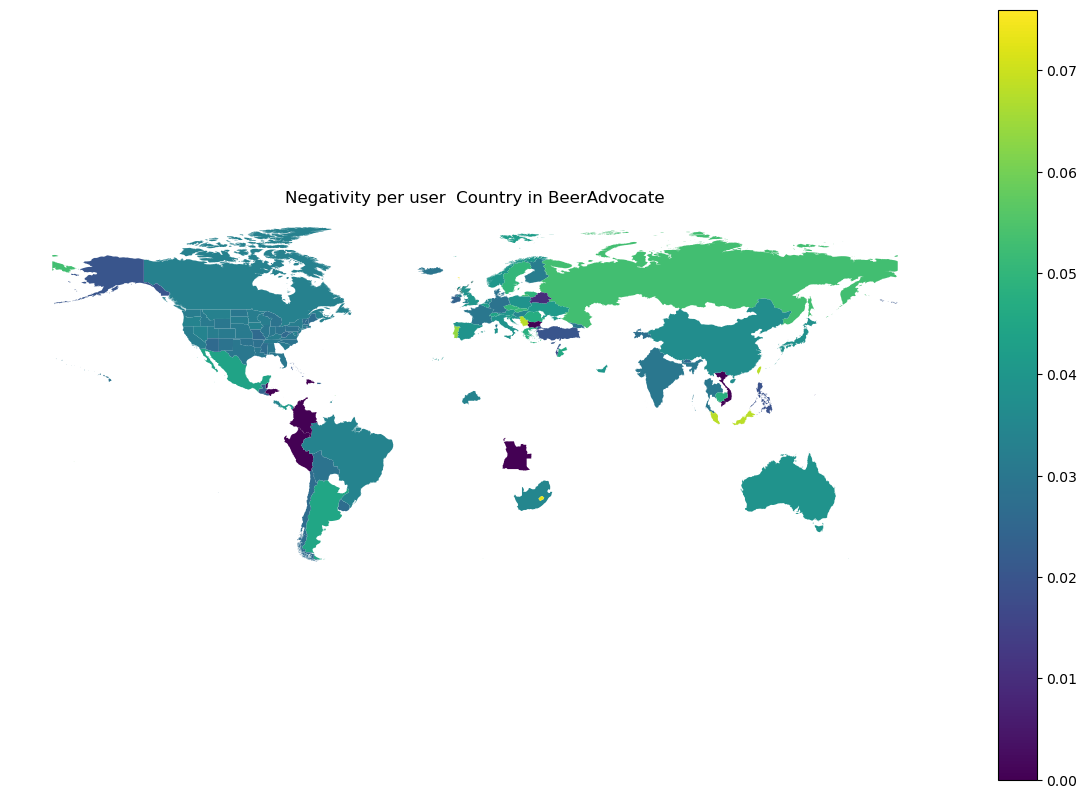

Elements of the column user_location that aren't in the shapefile :


,user_location,neg,mean,median
5,Ascension Island,"[0.118, 0.183, 0.176, 0.107, 0.045, 0.042, 0.1...",0.039112,0.000
16,Bosnia and Herzegovina,"[0.123, 0.351, 0.148, 0.204, 0.0, 0.0, 0.111, ...",0.040922,0.000
60,Laos,"[0.0, 0.0, 0.0, 0.0, 0.105, 0.0, 0.021, 0.039,...",0.036333,0.023
65,Macedonia,"[0.0, 0.062, 0.0, 0.04, 0.024, 0.053, 0.0, 0.0...",0.047605,0.043
82,North Korea,"[0.145, 0.0, 0.053, 0.0, 0.111, 0.28, 0.272, 0...",0.048720,0.000
87,Palestine,"[0.128, 0.0, 0.102, 0.05, 0.0, 0.0, 0.0, 0.121]",0.050125,0.025
97,Saint Helena,"[0.145, 0.052, 0.049, 0.077, 0.025, 0.109, 0.0...",0.079220,0.076
107,South Korea,"[0.063, 0.0, 0.05, 0.077, 0.0, 0.031, 0.0, 0.0...",0.049282,0.019
112,Tanzania,"[0.066, 0.028, 0.0, 0.0, 0.09, 0.0, 0.078, 0.0...",0.019962,0.000
172,Virgin Islands (U.S.),"[0.0, 0.0, 0.0, 0.169, 0.072, 0.034, 0.114, 0....",0.042077,0.017


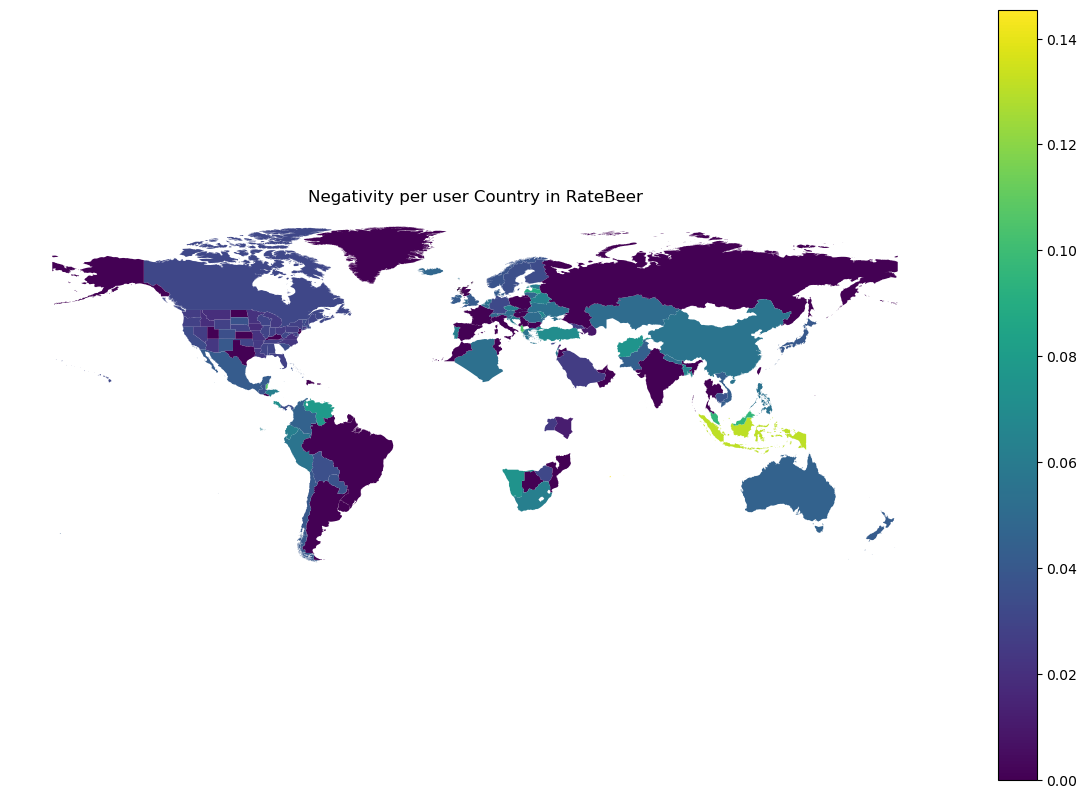

In [183]:
plot_map(df_neg_ba, shapefile, "Negativity per user ", "BeerAdvocate", 'median')
plot_map(df_neg_rb, shapefile, "Negativity per user", "RateBeer", 'median')


Elements of the column user_location that aren't in the shapefile :


,user_location,pos,mean,median
2,Antarctica,"[0.056, 0.143, 0.112, 0.052, 0.183, 0.194, 0.2...",0.139743,0.1360
3,Aotearoa,"[0.155, 0.092, 0.232, 0.111, 0.183, 0.138, 0.2...",0.146256,0.1360
15,Bosnia and Herzegovina,"[0.206, 0.052, 0.04, 0.08, 0.072, 0.059, 0.225...",0.133074,0.1120
34,Fiji Islands,"[0.145, 0.161, 0.169, 0.143, 0.054, 0.225, 0.1...",0.140170,0.1430
57,Macedonia,"[0.076, 0.18, 0.241, 0.175, 0.156, 0.153, 0.14...",0.156250,0.1545
77,South Georgia and South Sandwich Islands,"[0.149, 0.13, 0.147, 0.137, 0.083, 0.155, 0.08...",0.122938,0.1335
84,Tanzania,"[0.043, 0.081, 0.193, 0.12, 0.245, 0.206, 0.05...",0.156700,0.1590


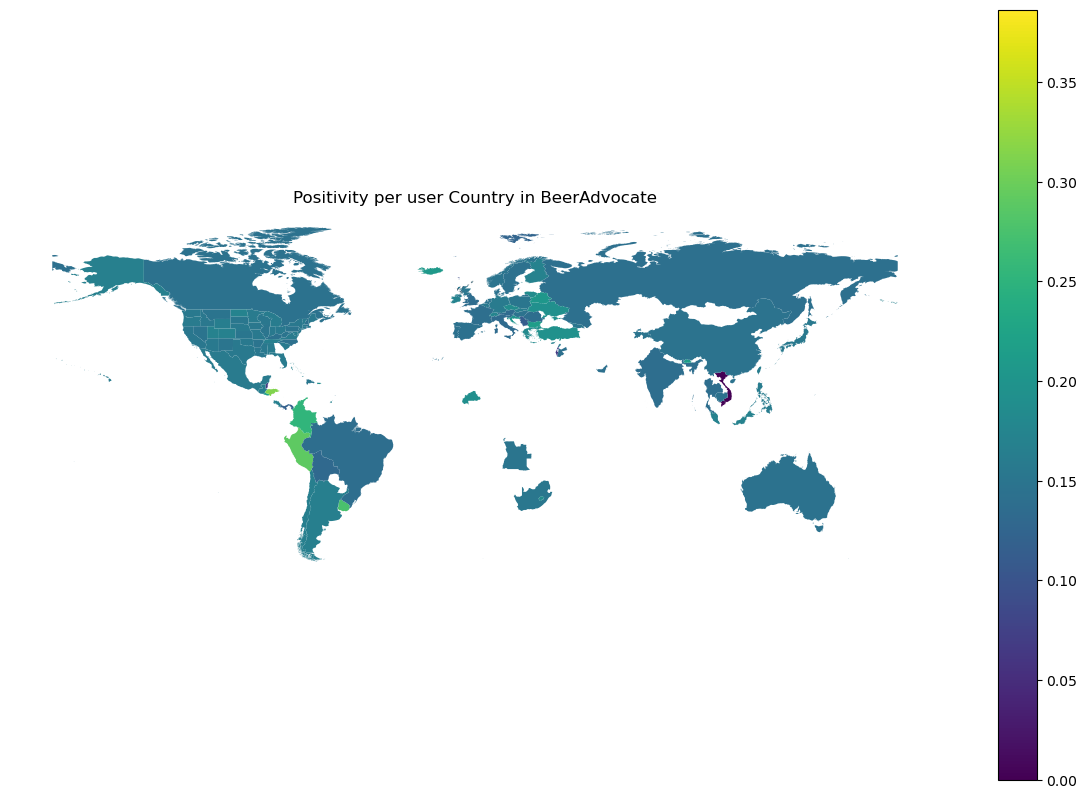

Elements of the column user_location that aren't in the shapefile :


,user_location,pos,mean,median
5,Ascension Island,"[0.04, 0.117, 0.071, 0.126, 0.136, 0.385, 0.04...",0.151517,0.1400
16,Bosnia and Herzegovina,"[0.192, 0.0, 0.045, 0.13, 0.0, 0.222, 0.0, 0.1...",0.131482,0.0330
60,Laos,"[0.288, 0.044, 0.049, 0.13, 0.116, 0.091, 0.09...",0.125000,0.0965
65,Macedonia,"[0.176, 0.278, 0.455, 0.086, 0.465, 0.369, 0.0...",0.189349,0.1760
82,North Korea,"[0.0, 0.221, 0.197, 0.208, 0.207, 0.0, 0.0, 0....",0.133195,0.1270
87,Palestine,"[0.153, 0.062, 0.275, 0.258, 0.261, 0.468, 0.4...",0.256750,0.2595
97,Saint Helena,"[0.122, 0.0, 0.0, 0.197, 0.118, 0.167, 0.226, ...",0.098417,0.0910
107,South Korea,"[0.116, 0.291, 0.167, 0.153, 0.293, 0.065, 0.1...",0.176475,0.1670
112,Tanzania,"[0.169, 0.157, 0.204, 0.128, 0.213, 0.214, 0.1...",0.180385,0.1785
172,Virgin Islands (U.S.),"[0.3, 0.21, 0.312, 0.108, 0.113, 0.233, 0.267,...",0.217667,0.2160


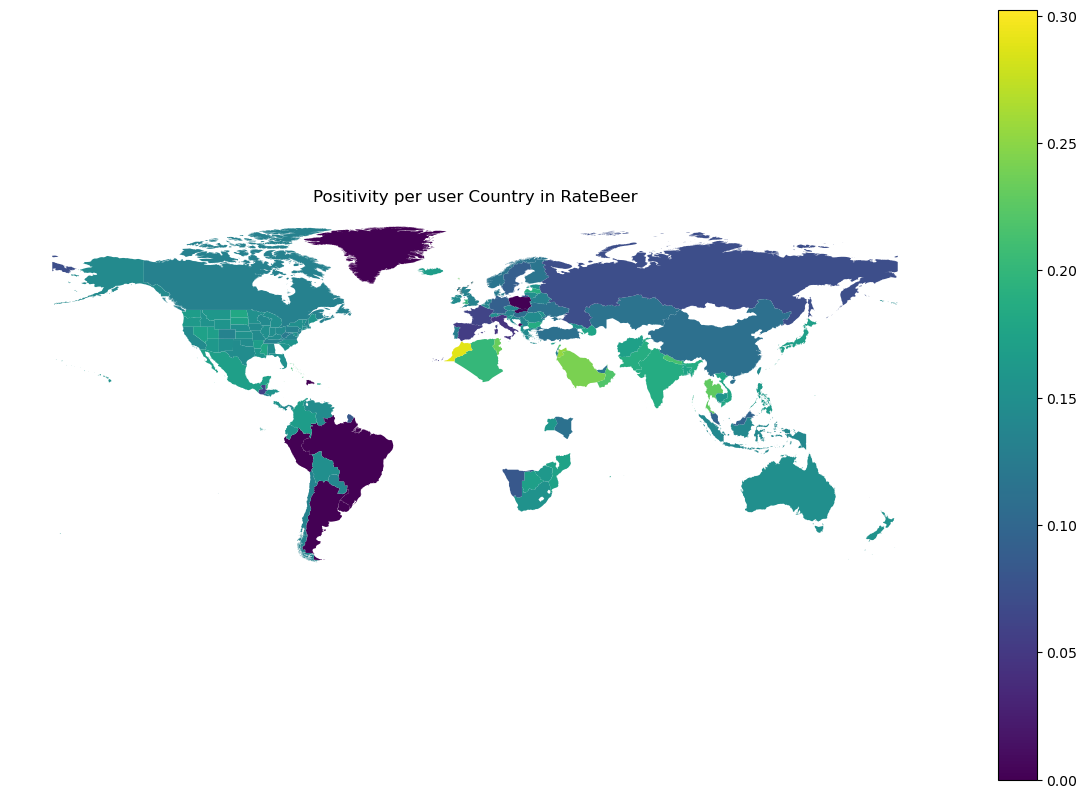

In [184]:
plot_map(df_pos_ba, shapefile, "Positivity per user", "BeerAdvocate", 'median')
plot_map(df_pos_rb, shapefile, "Positivity per user", "RateBeer",'median')

In BeerAdvocate we can observe that there is very few negativity in american reviews. In Europe and Asia people seem to leave comments with more negativity in them.
In RateBeer this is less visible.

In BeerAdvocate the positivity seems to be comparable around the world.
However in RateBeer american and african comments seem to contain more positivity than in their european counterparts.

Let us find 2 interresting breweries to explore, might not need for final version

In [185]:
# sort df_neg_ba_brwe by median
df_neg_ba_brwe = df_neg_ba_brwe.sort_values(by='median', ascending=False)
df_pos_ba_brwe = df_pos_ba_brwe.sort_values(by='median', ascending=False)
df_neg_rb_brwe = df_neg_rb_brwe.sort_values(by='median', ascending=False)
df_pos_rb_brwe = df_pos_rb_brwe.sort_values(by='median', ascending=False)

# only keep the lines with more than 50 elements in neg
df_neg_ba_brwe_sh = df_neg_ba_brwe[df_neg_ba_brwe['neg'].apply(len) > 50]
df_pos_ba_brwe_sh = df_pos_ba_brwe[df_pos_ba_brwe['pos'].apply(len) > 50]
df_neg_rb_brwe_sh = df_neg_rb_brwe[df_neg_rb_brwe['neg'].apply(len) > 50]
df_pos_rb_brwe_sh = df_pos_rb_brwe[df_pos_rb_brwe['pos'].apply(len) > 50]


display(df_neg_ba_brwe)
#display(df_pos_ba_brwe)
#display(df_neg_rb_brwe)
#display(df_pos_rb_brwe)

#display(df_neg_ba_brwe_sh)
#display(df_pos_ba_brwe_sh)
#display(df_neg_rb_brwe_sh)
#display(df_pos_rb_brwe_sh)

# save the 10 first and last lines of each datafram in a csv
# Get the head (first 10 rows) and tail (last 10 rows)
head_n = df_neg_ba_brwe_sh.head(10)
tail_n = df_neg_ba_brwe_sh.tail(10)
head_p = df_pos_ba_brwe_sh.head(10)
tail_p = df_pos_ba_brwe_sh.tail(10)

# Concatenate head and tail vertically
combined = pd.concat([head_n, tail_n, head_p, tail_p])

# Save the combined DataFrame to a CSV file
combined.to_csv('../results/df_ba_brwe.csv', index=False)

# Get the head (first 10 rows) and tail (last 10 rows)
head_n = df_neg_rb_brwe_sh.head(10)
tail_n = df_neg_rb_brwe_sh.tail(10)
head_p = df_pos_rb_brwe_sh.head(10)
tail_p = df_pos_rb_brwe_sh.tail(10)

# Concatenate head and tail vertically
combined = pd.concat([head_n, tail_n, head_p, tail_p])

# Save the combined DataFrame to a CSV file
combined.to_csv('../results/df_rb_brwe.csv', index=False)

# oder df_neg_ba_brwe_sh by length of neg
df_neg_rb_brwe_sh = df_neg_rb_brwe_sh.sort_values(by='neg', ascending=False)


#display the 20 first lines
display(df_neg_rb_brwe_sh.head(20))

# is 'Miller' in the brewery_name df_neg_rb_brwe_sh
print("is 'Miller' in the brewery_name df_neg_rb_brwe_sh :")
display(df_neg_rb_brwe_sh[df_neg_rb_brwe_sh['brewery_name'].str.contains("Miller")])

# display length of neg in Millers Brewery in df_neg_rb_brwe_sh
print("length of neg in Millers Brewery in df_neg_rb_brwe_sh :")
display(df_neg_rb_brwe_sh[df_neg_rb_brwe_sh['brewery_name'].str.contains("Millers Brewery")]['neg'].apply(len))

#display the following 20
#display(df_neg_ba_brwe_sh.iloc[20:40])

#display the following 20
#display(df_neg_ba_brwe_sh.iloc[40:60])

#display the following 20
#display(df_neg_ba_brwe_sh.iloc[60:80])


#sort df_neg_ba_brwe_sh by mean
df_neg_ba_brwe_sh = df_neg_ba_brwe_sh.sort_values(by='mean', ascending=False)

#display the 20 first lines
display(df_neg_ba_brwe_sh.head(20))
#display the last 20 lines
display(df_neg_ba_brwe_sh.tail(20))

#sort df_neg_rb_brwe_sh by median
df_neg_rb_brwe_sh = df_neg_rb_brwe_sh.sort_values(by='median', ascending=False)

#display the 20 first lines
display(df_neg_rb_brwe_sh.head(20))

#display the last 20 lines
display(df_neg_rb_brwe_sh.tail(20))

# in df_work_ba, nb of countries with Miller brewery_name
print("nb of countries with Miller brewery_name :")
display(df_work_ba[df_work_ba['brewery_name'] == 'Miller Brewing Co.']['user_location'].nunique())

# in df_work_ba, nb of countries with Anheuser-Bush brewery_name
print("nb of countries with Anheuser-Bush brewery_name :")
display(df_work_ba[df_work_ba['brewery_name'] == 'Anheuser-Busch']['user_location'].nunique())

# in df_work_ba, nb of countries with Heineken brewery_name
print("nb of countries with Heineken brewery_name :")
display(df_work_ba[df_work_ba['brewery_name'] == 'Heineken Nederland B.V.']['user_location'].nunique())

# in df_work_ba, nb of countries with Carlsberg brewery_name
print("nb of countries with Carlsberg brewery_name :")
display(df_work_ba[df_work_ba['brewery_name'] == 'Carlsberg Danmark A/S']['user_location'].nunique())

# in df_work_ba, nb of countries with Weihenstephan brewery_name
print("nb of countries with Weihenstephan brewery_name :")
display(df_work_ba[df_work_ba['brewery_name'] == 'Bayerische Staatsbrauerei Weihenstephan']['user_location'].nunique())

# in df_work_ba, nb of countries with Chimay brewery_name
print("nb of countries with Chimay brewery_name :")
display(df_work_ba[df_work_ba['brewery_name'] == 'Bières de Chimay']['user_location'].nunique())








,brewery_name,neg,mean,median
1857,Cerveza Frontera,"[0.08, 0.1, 0.217, 0.183, 0.134, 0.172]",0.147667,0.153
2383,Efes-Vitanta-Moldova Brewery S.A.,"[0.177, 0.077, 0.124, 0.156, 0.18, 0.108, 0.21...",0.131125,0.140
3909,Lovely Valley Beverage Factory,"[0.074, 0.173, 0.152, 0.076, 0.176, 0.135, 0.2...",0.136182,0.135
2836,Global Brands Ltd.,"[0.053, 0.214, 0.0, 0.481, 0.027, 0.134, 0.0, ...",0.132667,0.134
6224,Toboggan Brewing Co.,"[0.14, 0.033, 0.179, 0.0, 0.135, 0.133, 0.139,...",0.095111,0.133
...,...,...,...,...
4823,Pints Brewing Co.,"[0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11...",0.016545,0.000
4063,Mastry's Brewing Company,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.000
1277,Braugaststätte Döbler,"[0.0, 0.052, 0.02, 0.0, 0.0, 0.067, 0.0, 0.0]",0.017375,0.000
2235,Devils Brewery,"[0.0, 0.0, 0.0, 0.044, 0.0, 0.0]",0.007333,0.000


,brewery_name,neg,mean,median
1484,Bierfabrik Berlin,"[0.522, 0.063, 0.177, 0.04, 0.0, 0.03, 0.0, 0....",0.062441,0.0540
286,Ahold Czech Republic a.s.,"[0.467, 0.1, 0.0, 0.053, 0.0, 0.076, 0.1, 0.0,...",0.073637,0.0540
1015,Barda,"[0.451, 0.093, 0.091, 0.109, 0.095, 0.069, 0.0...",0.107714,0.0910
11514,Pinthouse Pizza,"[0.436, 0.06, 0.077, 0.081, 0.0, 0.175, 0.235,...",0.053778,0.0480
12929,Sandorf,"[0.419, 0.232, 0.057, 0.088, 0.057, 0.067, 0.0...",0.083147,0.0675
556,Apeldoornse Bierbrouwerij De Vlijt,"[0.419, 0.078, 0.0, 0.077, 0.092, 0.211, 0.0, ...",0.056482,0.0575
3455,Brouwerij de 7de Hemel,"[0.417, 0.064, 0.125, 0.129, 0.045, 0.0, 0.116...",0.053183,0.0480
6965,Great Flood Brewing Company,"[0.415, 0.0, 0.0, 0.028, 0.075, 0.0, 0.078, 0....",0.040557,0.0280
11423,Perła - Browary Lubelskie,"[0.413, 0.221, 0.299, 0.228, 0.188, 0.0, 0.036...",0.055644,0.0310
185,APU Company,"[0.403, 0.082, 0.084, 0.096, 0.0, 0.054, 0.0, ...",0.053651,0.0440


is 'Miller' in the brewery_name df_neg_rb_brwe_sh :


,brewery_name,neg,mean,median
4245,Cerveceria Hondureña (SABMiller),"[0.315, 0.0, 0.0, 0.035, 0.075, 0.0, 0.0, 0.14...",0.057747,0.0390
15008,Ursus Breweries (SABMiller),"[0.223, 0.037, 0.0, 0.088, 0.0, 0.104, 0.186, ...",0.067680,0.0570
4251,Cerveceria La Constancia (SABMiller),"[0.203, 0.086, 0.0, 0.162, 0.041, 0.069, 0.0, ...",0.072317,0.0550
4885,Compañia Cervecera de Canarias (SABMiller),"[0.146, 0.0, 0.296, 0.038, 0.0, 0.0, 0.045, 0....",0.069067,0.0590
4260,Cerveceria Nacional Panama (SABMiller),"[0.133, 0.068, 0.151, 0.151, 0.0, 0.048, 0.044...",0.066976,0.0630
7083,Grupo Empresarial Bavaria (SABMiller),"[0.131, 0.052, 0.034, 0.042, 0.146, 0.0, 0.036...",0.064609,0.0510
12842,Saint Archer Brewing Company &#40;MillerCoors&...,"[0.114, 0.0, 0.049, 0.061, 0.018, 0.1, 0.0, 0....",0.045895,0.0370
5629,Dreher Sörgyárak (SABMiller),"[0.093, 0.0, 0.1, 0.189, 0.088, 0.138, 0.133, ...",0.075509,0.0590
12424,Revolver Brewing &#40;MillerCoors&#41;,"[0.092, 0.011, 0.0, 0.0, 0.0, 0.0, 0.0, 0.166,...",0.038043,0.0000
3930,C.A.S.A. Isenbeck (SABMiller),"[0.09, 0.152, 0.211, 0.0, 0.0, 0.083, 0.073, 0...",0.070027,0.0610


length of neg in Millers Brewery in df_neg_rb_brwe_sh :


10113    155
Name: neg, dtype: int64

,brewery_name,neg,mean,median
1681,Camo Brewing Company,"[0.139, 0.277, 0.0, 0.095, 0.024, 0.108, 0.05,...",0.094642,0.0880
5883,Tall Tales Brewing Company,"[0.054, 0.127, 0.0, 0.0, 0.0, 0.039, 0.212, 0....",0.091230,0.0650
1964,Coastal Fog Brewing,"[0.144, 0.051, 0.061, 0.01, 0.065, 0.157, 0.02...",0.084587,0.0720
3647,Krönleins Bryggeri AB,"[0.059, 0.045, 0.244, 0.038, 0.12, 0.084, 0.18...",0.083034,0.0630
4540,Oettinger Brauerei,"[0.022, 0.025, 0.007, 0.045, 0.0, 0.102, 0.133...",0.080450,0.0495
1815,Cervecería Polar,"[1.0, 0.092, 0.09, 0.037, 0.07, 0.024, 0.057, ...",0.080032,0.0450
1908,Chili Beer Co.,"[0.127, 0.0, 0.016, 0.0, 0.06, 0.0, 0.022, 0.0...",0.077891,0.0690
4222,MobCraft Beer,"[0.0, 0.0, 0.066, 0.164, 0.037, 0.338, 0.336, ...",0.076654,0.0460
5464,Shaw Wallace & Company Ltd.,"[0.09, 0.091, 0.021, 0.18, 0.154, 0.859, 0.039...",0.076442,0.0560
5331,Saint Ides Brewing Company,"[0.041, 0.038, 0.096, 0.341, 0.0, 0.05, 0.075,...",0.076397,0.0590


,brewery_name,neg,mean,median
3337,Icicle Brewing Company,"[0.01, 0.01, 0.046, 0.0, 0.0, 0.0, 0.0, 0.023,...",0.024500,0.0215
3195,Hofbräu Kaltenhausen (Brau Union),"[0.036, 0.094, 0.031, 0.039, 0.0, 0.024, 0.0, ...",0.024471,0.0175
6739,Yonkers Brewing Co.,"[0.008, 0.0, 0.0, 0.025, 0.034, 0.031, 0.0, 0....",0.024352,0.0245
1479,Brouwerij Rodenbach N.V.,"[0.052, 0.019, 0.065, 0.0, 0.038, 0.0, 0.029, ...",0.024289,0.0190
6417,Urban Artifact,"[0.0, 0.0, 0.04, 0.031, 0.179, 0.012, 0.051, 0...",0.024123,0.0120
1769,Central State Brewing,"[0.016, 0.048, 0.0, 0.0, 0.0, 0.0, 0.051, 0.0,...",0.023613,0.0100
5434,Second Self Beer Company,"[0.018, 0.047, 0.0, 0.0, 0.028, 0.074, 0.0, 0....",0.023579,0.0000
2830,Glacier Brewhouse,"[0.0, 0.027, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.023569,0.0000
1366,BrickHouse Brewery,"[0.0, 0.077, 0.052, 0.055, 0.0, 0.0, 0.035, 0....",0.023438,0.0000
5850,"Swashbuckler Brewing Co, LTD","[0.068, 0.0, 0.067, 0.0, 0.04, 0.02, 0.0, 0.03...",0.023327,0.0170


,brewery_name,neg,mean,median
5533,Dolce Vela S.R.L.,"[0.211, 0.289, 0.157, 0.197, 0.098, 0.069, 0.2...",0.126458,0.1190
808,BIP-Beogradska Industrija Piva,"[0.158, 0.0, 0.263, 0.075, 0.092, 0.147, 0.114...",0.112920,0.1180
15046,Valge Pruulikoda,"[0.045, 0.125, 0.291, 0.115, 0.196, 0.034, 0.2...",0.133031,0.1015
10448,Mõtsalise Pruulikoda,"[0.0, 0.0, 0.11, 0.076, 0.078, 0.182, 0.146, 0...",0.098962,0.1005
15009,Urwibutso Enterprise,"[0.0, 0.226, 0.295, 0.13, 0.036, 0.0, 0.132, 0...",0.108190,0.0970
5953,Eridan,"[0.052, 0.05, 0.153, 0.135, 0.097, 0.239, 0.21...",0.100193,0.0970
11753,Pivzavod AO Hamovniki,"[0.0, 0.206, 0.174, 0.095, 0.027, 0.124, 0.212...",0.101931,0.0970
12396,Reschs (CUB),"[0.0, 0.0, 0.035, 0.147, 0.127, 0.035, 0.178, ...",0.109376,0.0950
7702,Holu,"[0.175, 0.15, 0.085, 0.12, 0.057, 0.206, 0.09,...",0.111949,0.0940
13242,Shirak Gyumri Beer-Malt Factory CJSC,"[0.169, 0.147, 0.151, 0.062, 0.0, 0.275, 0.189...",0.103049,0.0940


,brewery_name,neg,mean,median
13575,Spellbound Brewing,"[0.0, 0.0, 0.09, 0.062, 0.0, 0.124, 0.068, 0.0...",0.036836,0.0
3580,Browar Piwoteka,"[0.0, 0.0, 0.091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.037212,0.0
10879,Octopi Brewing Company,"[0.0, 0.0, 0.091, 0.0, 0.0, 0.0, 0.088, 0.0, 0...",0.039340,0.0
913,Baerlic Brewing,"[0.0, 0.0, 0.091, 0.0, 0.0, 0.08, 0.0, 0.0, 0....",0.032902,0.0
8233,Jailbreak Brewing Company,"[0.017, 0.048, 0.0, 0.0, 0.0, 0.0, 0.058, 0.0,...",0.030195,0.0
5403,Desert Edge Brewery,"[0.0, 0.0, 0.092, 0.085, 0.0, 0.131, 0.047, 0....",0.036932,0.0
3621,Browar Wąsosz,"[0.157, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07, 0....",0.039171,0.0
9541,Lupine Brewing Company,"[0.0, 0.0, 0.093, 0.0, 0.0, 0.028, 0.0, 0.0, 0...",0.023933,0.0
10897,Odonata Beer Company,"[0.015, 0.023, 0.0, 0.0, 0.0, 0.017, 0.0, 0.07...",0.024037,0.0
8220,Jackdaw Brewery,"[0.158, 0.0, 0.065, 0.0, 0.033, 0.027, 0.034, ...",0.040805,0.0


nb of countries with Miller brewery_name :


88

nb of countries with Anheuser-Bush brewery_name :


102

nb of countries with Heineken brewery_name :


102

nb of countries with Carlsberg brewery_name :


83

nb of countries with Weihenstephan brewery_name :


101

nb of countries with Chimay brewery_name :


105

We will explore the sentiments about two large breweries, Millers and Weihenstephan around the world.
For that we will breakfown our df by origin, user_country, brewery and sentiment.

In [186]:
#display(df_work_ba)

# create a new df with brewery_name, user_location, neg, pos
df_ba_brwe_loc = df_work_ba[['brewery_name', 'user_location', 'neg', 'pos']]
df_rb_brwe_loc = df_work_rb[['brewery_name', 'user_location', 'neg', 'pos']]

# create a new df with all the unique countries and add a column negs and poss
df_ba_brwe_loc_unique = df_ba_brwe_loc[['user_location']].drop_duplicates()
df_ba_brwe_loc_unique['negs'] = ''
df_ba_brwe_loc_unique['poss'] = ''

# create a new df with all the unique countries and add a column negs and poss
df_rb_brwe_loc_unique = df_rb_brwe_loc[['user_location']].drop_duplicates()
df_rb_brwe_loc_unique['negs'] = ''
df_rb_brwe_loc_unique['poss'] = ''

# create df_rb_brwe_loc_unique_W, a copy of df_rb_brwe_loc_unique
df_rb_brwe_loc_unique_W = df_rb_brwe_loc_unique.copy()

# create df_ba_brwe_loc_unique_W, a copy of df_ba_brwe_loc_unique
df_ba_brwe_loc_unique_W = df_ba_brwe_loc_unique.copy()

# create df_rb_brwe_loc_unique_M, a copy of df_rb_brwe_loc_unique
df_rb_brwe_loc_unique_M = df_rb_brwe_loc_unique.copy()

# create df_ba_brwe_loc_unique_M, a copy of df_ba_brwe_loc_unique
df_ba_brwe_loc_unique_M = df_ba_brwe_loc_unique.copy()

In [187]:
# for each country, put the neg and pos of all appearences of Weihenstaphan in brewery_name and the country in negs and poss
for index, row in tqdm(df_ba_brwe_loc_unique.iterrows(), total=len(df_ba_brwe_loc_unique)):
    df_ba_brwe_loc_unique_W.at[index, 'negs'] = df_ba_brwe_loc[(df_ba_brwe_loc['user_location'] == row['user_location']) & (df_ba_brwe_loc['brewery_name'] == 'Bayerische Staatsbrauerei Weihenstephan')]['neg'].tolist()
    df_ba_brwe_loc_unique_W.at[index, 'poss'] = df_ba_brwe_loc[(df_ba_brwe_loc['user_location'] == row['user_location']) & (df_ba_brwe_loc['brewery_name'] == 'Bayerische Staatsbrauerei Weihenstephan')]['pos'].tolist()

for index, row in tqdm(df_rb_brwe_loc_unique.iterrows(), total=len(df_rb_brwe_loc_unique)):
    df_rb_brwe_loc_unique_W.at[index, 'negs'] = df_rb_brwe_loc[(df_rb_brwe_loc['user_location'] == row['user_location']) & (df_rb_brwe_loc['brewery_name'] == 'Bayerische Staatsbrauerei Weihenstephan')]['neg'].tolist()
    df_rb_brwe_loc_unique_W.at[index, 'poss'] = df_rb_brwe_loc[(df_rb_brwe_loc['user_location'] == row['user_location']) & (df_rb_brwe_loc['brewery_name'] == 'Bayerische Staatsbrauerei Weihenstephan')]['pos'].tolist()

100%|██████████| 221/221 [04:05<00:00,  1.11s/it]


In [188]:

# for each country, put the neg and pos of all appearences of Miller in brewery_name and the country in negs and poss
for index, row in tqdm(df_ba_brwe_loc_unique.iterrows(), total=len(df_ba_brwe_loc_unique)):
    df_ba_brwe_loc_unique_M.at[index, 'negs'] = df_ba_brwe_loc[(df_ba_brwe_loc['user_location'] == row['user_location']) & (df_ba_brwe_loc['brewery_name'] == 'Miller Brewing Co.')]['neg'].tolist()
    df_ba_brwe_loc_unique_M.at[index, 'poss'] = df_ba_brwe_loc[(df_ba_brwe_loc['user_location'] == row['user_location']) & (df_ba_brwe_loc['brewery_name'] == 'Miller Brewing Co.')]['pos'].tolist()

for index, row in tqdm(df_rb_brwe_loc_unique.iterrows(), total=len(df_rb_brwe_loc_unique)):
    df_rb_brwe_loc_unique_M.at[index, 'negs'] = df_rb_brwe_loc[(df_rb_brwe_loc['user_location'] == row['user_location']) & (df_rb_brwe_loc['brewery_name'] == 'Millers Brewery')]['neg'].tolist()
    df_rb_brwe_loc_unique_M.at[index, 'poss'] = df_rb_brwe_loc[(df_rb_brwe_loc['user_location'] == row['user_location']) & (df_rb_brwe_loc['brewery_name'] == 'Millers Brewery')]['pos'].tolist()


100%|██████████| 221/221 [04:05<00:00,  1.11s/it]


In [189]:
# remove the lines where negs are empty (neg and pos are always generated together)
df_ba_brwe_loc_unique_W = df_ba_brwe_loc_unique_W[df_ba_brwe_loc_unique_W['negs'].apply(len) > 0]

display(df_ba_brwe_loc_unique_W)

,user_location,negs,poss
0,"United States, Washington","[0.0, 0.0, 0.012, 0.0, 0.052, 0.02, 0.048, 0.0...","[0.269, 0.106, 0.149, 0.031, 0.119, 0.134, 0.1..."
1,"United States, New York","[0.0, 0.0, 0.012, 0.034, 0.049, 0.0, 0.055, 0....","[0.345, 0.125, 0.106, 0.211, 0.101, 0.276, 0.2..."
2,Northern Ireland,"[0.023, 0.015, 0.095, 0.0, 0.019, 0.0, 0.0, 0....","[0.211, 0.135, 0.073, 0.182, 0.205, 0.169, 0.1..."
5,"United States, North Carolina","[0.0, 0.014, 0.069, 0.043, 0.031, 0.015, 0.033...","[0.298, 0.097, 0.104, 0.188, 0.268, 0.064, 0.0..."
7,"United States, Illinois","[0.0, 0.086, 0.039, 0.024, 0.019, 0.023, 0.084...","[0.133, 0.222, 0.144, 0.19, 0.191, 0.181, 0.18..."
...,...,...,...
51142,Lithuania,[0.0],[0.221]
61210,Chile,[0.012],[0.188]
81987,Tajikistan,[0.02],[0.101]
87225,Tanzania,[0.055],[0.221]


In [190]:


# remove the lines where negs are empty (neg and pos are always generated together)
df_rb_brwe_loc_unique_W = df_rb_brwe_loc_unique_W[df_rb_brwe_loc_unique_W['negs'].apply(len) > 0]

# remove the lines where negs are empty (neg and pos are always generated together)
df_ba_brwe_loc_unique_M = df_ba_brwe_loc_unique_M[df_ba_brwe_loc_unique_M['negs'].apply(len) > 0]

# remove the lines where negs are empty (neg and pos are always generated together)
df_rb_brwe_loc_unique_M = df_rb_brwe_loc_unique_M[df_rb_brwe_loc_unique_M['negs'].apply(len) > 0]

Now that we have cleaned our dfs, we will compare the sentiment of the two breweries around the world.

In [191]:
# take the mean of the negs and put in new column neg
df_ba_brwe_loc_unique_W['neg'] = df_ba_brwe_loc_unique_W['negs'].apply(np.mean)
# take the mean of the poss and put in new column pos
df_ba_brwe_loc_unique_W['pos'] = df_ba_brwe_loc_unique_W['poss'].apply(np.mean)

# take the mean of the negs and put in new column neg
df_rb_brwe_loc_unique_W['neg'] = df_rb_brwe_loc_unique_W['negs'].apply(np.mean)
# take the mean of the poss and put in new column pos
df_rb_brwe_loc_unique_W['pos'] = df_rb_brwe_loc_unique_W['poss'].apply(np.mean)

# take the mean of the negs and put in new column neg
df_ba_brwe_loc_unique_M['neg'] = df_ba_brwe_loc_unique_M['negs'].apply(np.mean)
# take the mean of the poss and put in new column pos
df_ba_brwe_loc_unique_M['pos'] = df_ba_brwe_loc_unique_M['poss'].apply(np.mean)

# take the mean of the negs and put in new column neg
df_rb_brwe_loc_unique_M['neg'] = df_rb_brwe_loc_unique_M['negs'].apply(np.mean)
# take the mean of the poss and put in new column pos
df_rb_brwe_loc_unique_M['pos'] = df_rb_brwe_loc_unique_M['poss'].apply(np.mean)



# create a df_comp with the country and the difference between the mean of the country and neg of df_ba_brwe_loc_unique
df_comp_neg_ba_W = df_ba_brwe_loc_unique_W[['user_location', 'neg']]
df_comp_neg_ba_W['diff'] = df_comp_neg_ba_W['neg'] - df_comp_neg_ba_W['neg'].mean()
df_comp_pos_ba_W = df_ba_brwe_loc_unique_W[['user_location', 'pos']]
df_comp_pos_ba_W['diff'] = df_comp_pos_ba_W['pos'] - df_comp_pos_ba_W['pos'].mean()

# create a df_comp with the country and the difference between the mean of the country and neg of df_rb_brwe_loc_unique
df_comp_rb_W = df_rb_brwe_loc_unique_W[['user_location', 'neg']]
df_comp_rb_W['diff'] = df_comp_rb_W['neg'] - df_comp_rb_W['neg'].mean()
df_comp_pos_rb_W = df_rb_brwe_loc_unique_W[['user_location', 'pos']]
df_comp_pos_rb_W['diff'] = df_comp_pos_rb_W['pos'] - df_comp_pos_rb_W['pos'].mean()

# create a df_comp with the country and the difference between the mean of the country and neg of df_ba_brwe_loc_unique
df_comp_neg_ba_M = df_ba_brwe_loc_unique_M[['user_location', 'neg']]
df_comp_neg_ba_M['diff'] = df_comp_neg_ba_M['neg'] - df_comp_neg_ba_M['neg'].mean()
df_comp_pos_ba_M = df_ba_brwe_loc_unique_M[['user_location', 'pos']]
df_comp_pos_ba_M['diff'] = df_comp_pos_ba_M['pos'] - df_comp_pos_ba_M['pos'].mean()

# create a df_comp with the country and the difference between the mean of the country and neg of df_rb_brwe_loc_unique
df_comp_rb_M = df_rb_brwe_loc_unique_M[['user_location', 'neg']]
df_comp_rb_M['diff'] = df_comp_rb_M['neg'] - df_comp_rb_M['neg'].mean()
df_comp_pos_rb_M = df_rb_brwe_loc_unique_M[['user_location', 'pos']]
df_comp_pos_rb_M['diff'] = df_comp_pos_rb_M['pos'] - df_comp_pos_rb_M['pos'].mean()

C:\Users\ben\AppData\Local\Temp\ipykernel_9468\2504790235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comp_neg_ba_W['diff'] = df_comp_neg_ba_W['neg'] - df_comp_neg_ba_W['neg'].mean()
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\2504790235.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comp_pos_ba_W['diff'] = df_comp_pos_ba_W['pos'] - df_comp_pos_ba_W['pos'].mean()
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\2504790235.py:31: SettingWithCopyWarning: 
A value is trying to be set on a

Elements of the column user_location that aren't in the shapefile :


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("United States, ", "")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,user_location,pos,diff
5832,Antarctica,0.080667,-0.04198


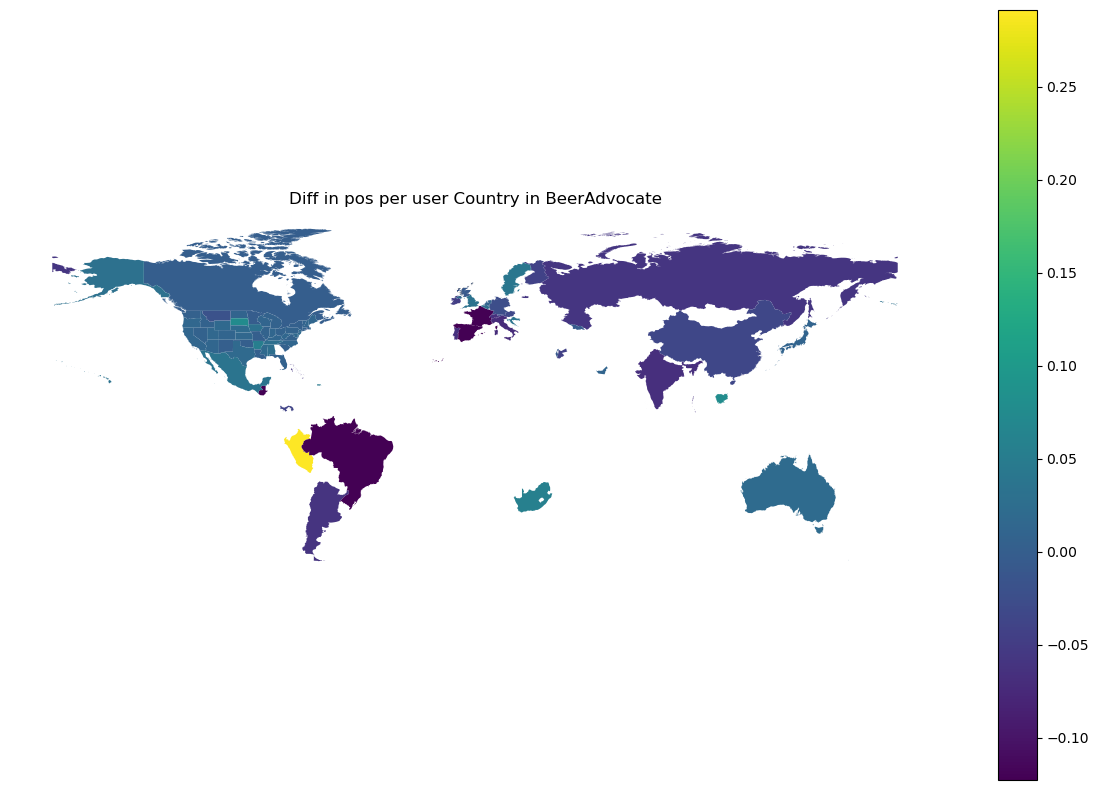

Elements of the column user_location that aren't in the shapefile :


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("United States, ", "")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,user_location,neg,diff
5832,Antarctica,0.058,-0.013161


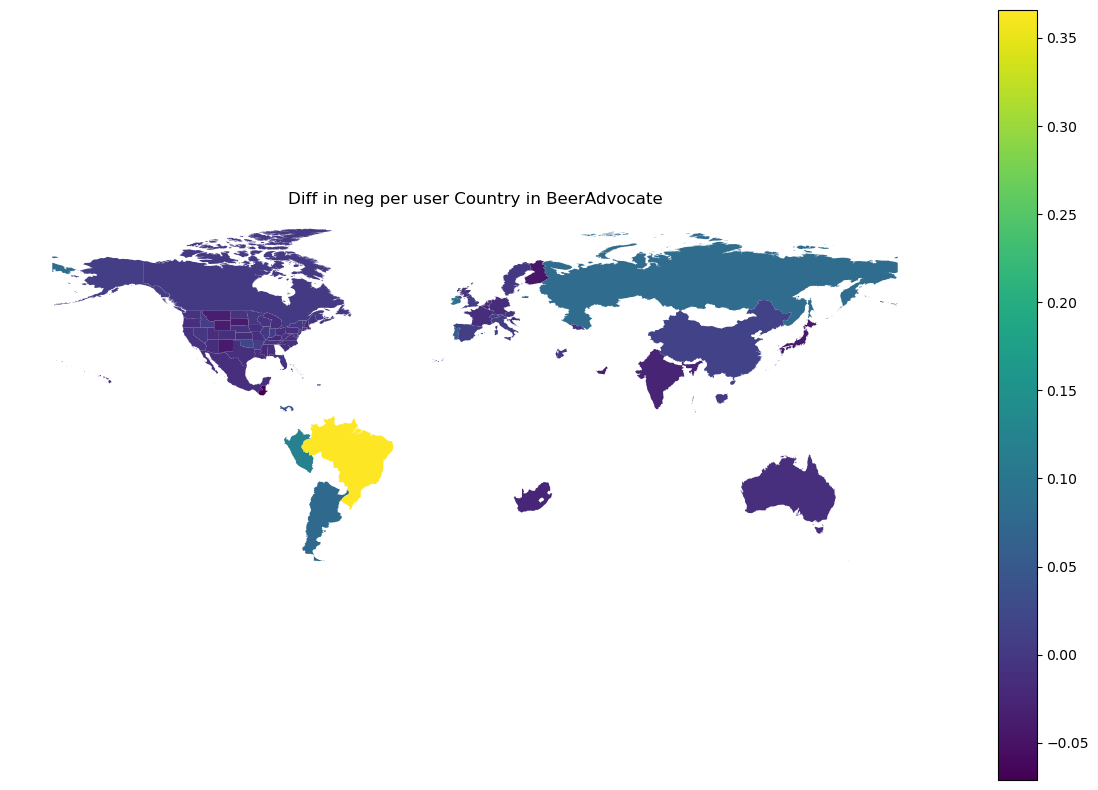

Elements of the column user_location that aren't in the shapefile :


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("United States, ", "")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,user_location,pos,diff


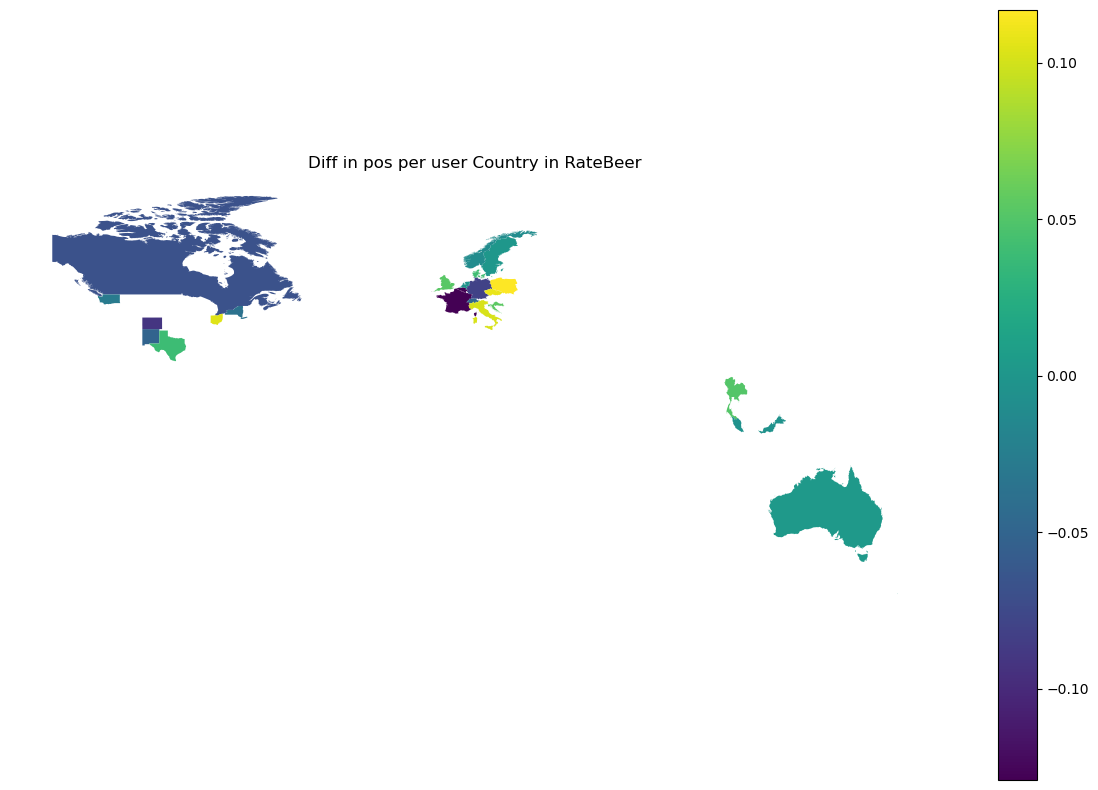

Elements of the column user_location that aren't in the shapefile :


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("United States, ", "")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,user_location,neg,diff


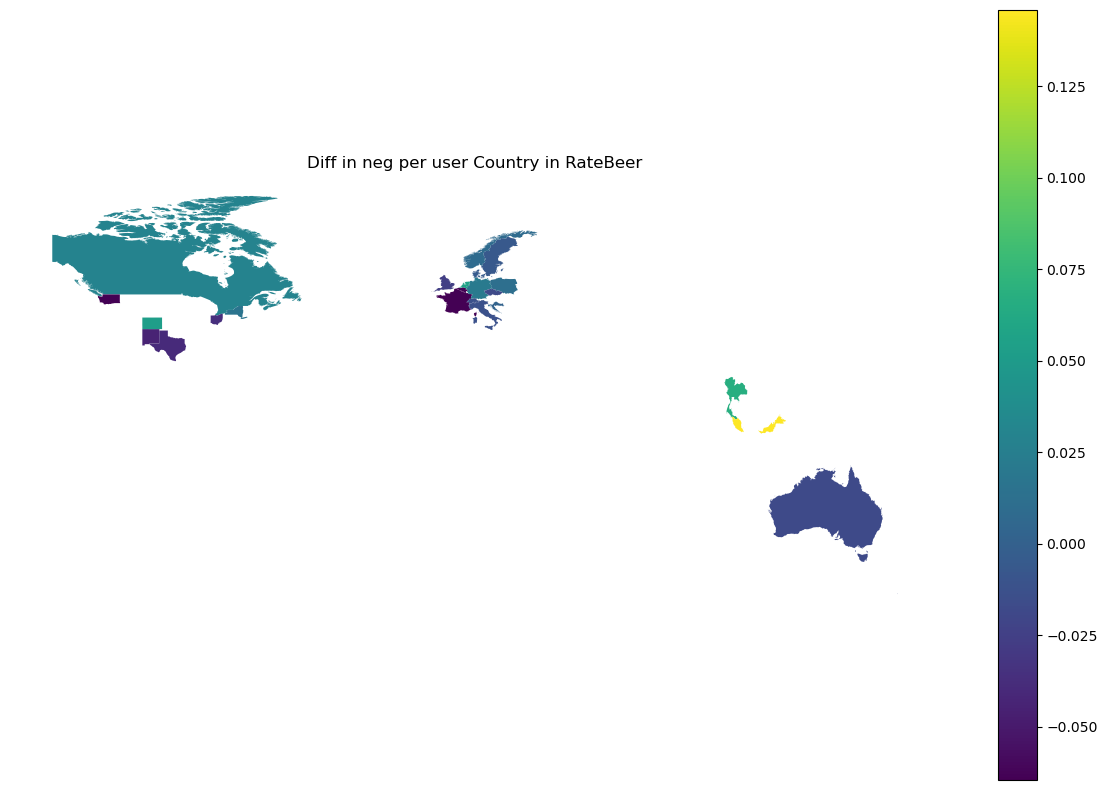

Elements of the column user_location that aren't in the shapefile :


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("United States, ", "")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,user_location,pos,diff
87225,Tanzania,0.221,0.032831


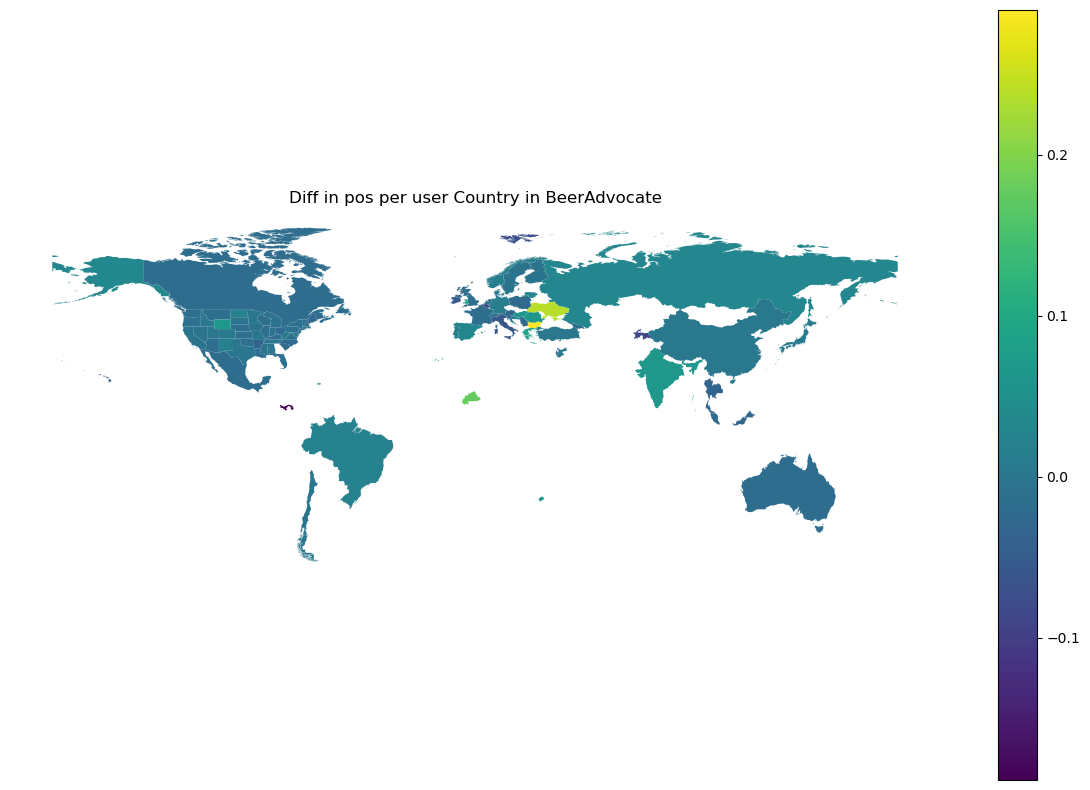

Elements of the column user_location that aren't in the shapefile :


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("United States, ", "")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,user_location,neg,diff
87225,Tanzania,0.055,0.029516


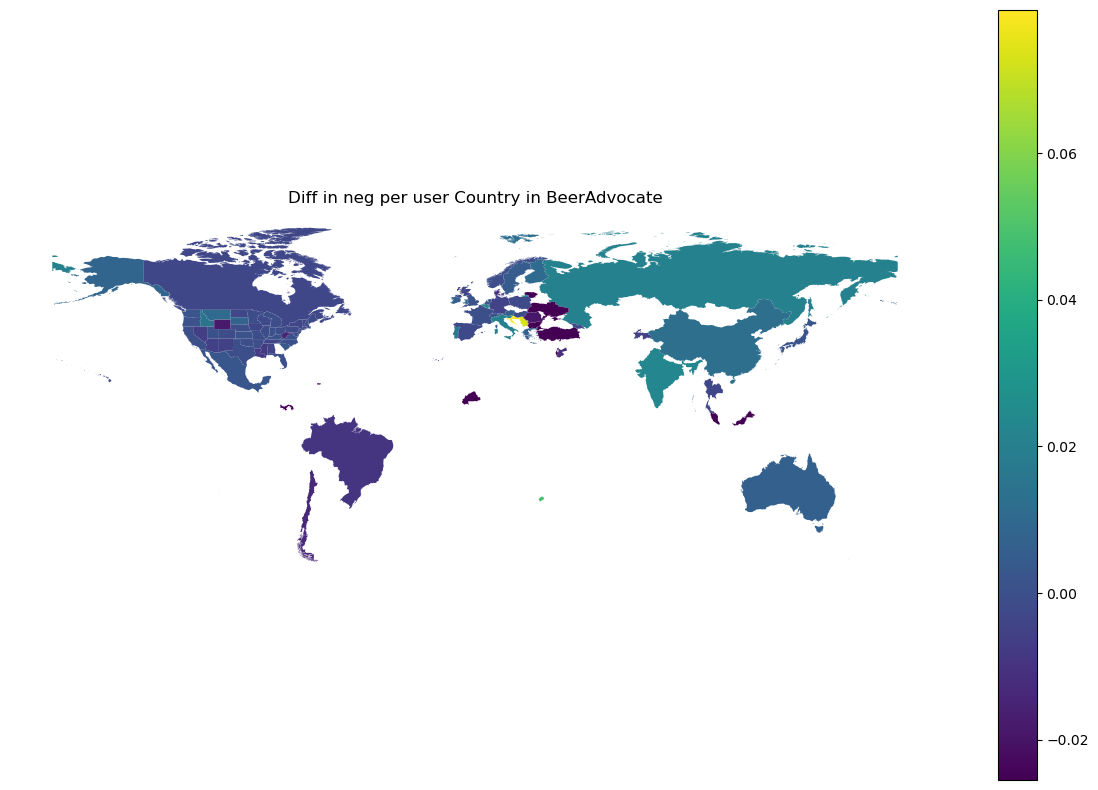

Elements of the column user_location that aren't in the shapefile :


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("United States, ", "")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,user_location,pos,diff
5121,Ascension Island,0.1918,0.014207
6304,North Korea,0.1470,-0.030593
6971,South Korea,0.2517,0.074107
465794,Saint Helena,0.1970,0.019407


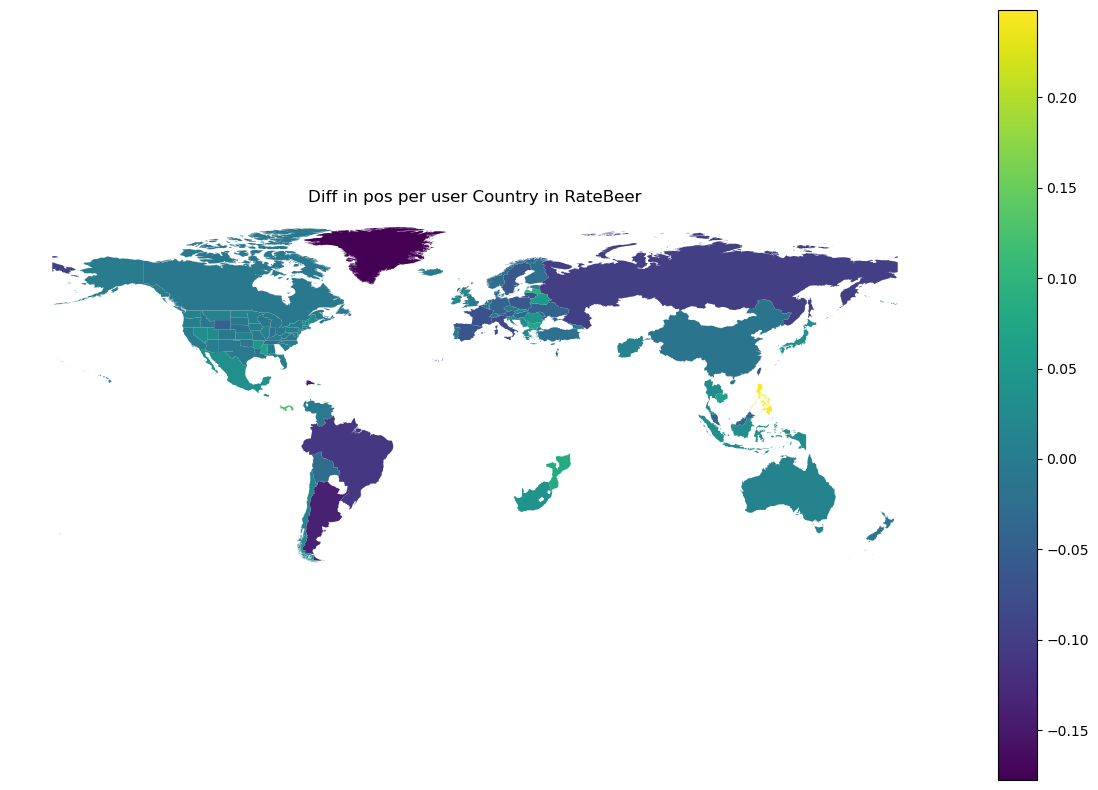

Elements of the column user_location that aren't in the shapefile :


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("United States, ", "")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,user_location,neg,diff
5121,Ascension Island,0.02520,-0.00857
6304,North Korea,0.01425,-0.01952
6971,South Korea,0.02920,-0.00457
465794,Saint Helena,0.07700,0.04323


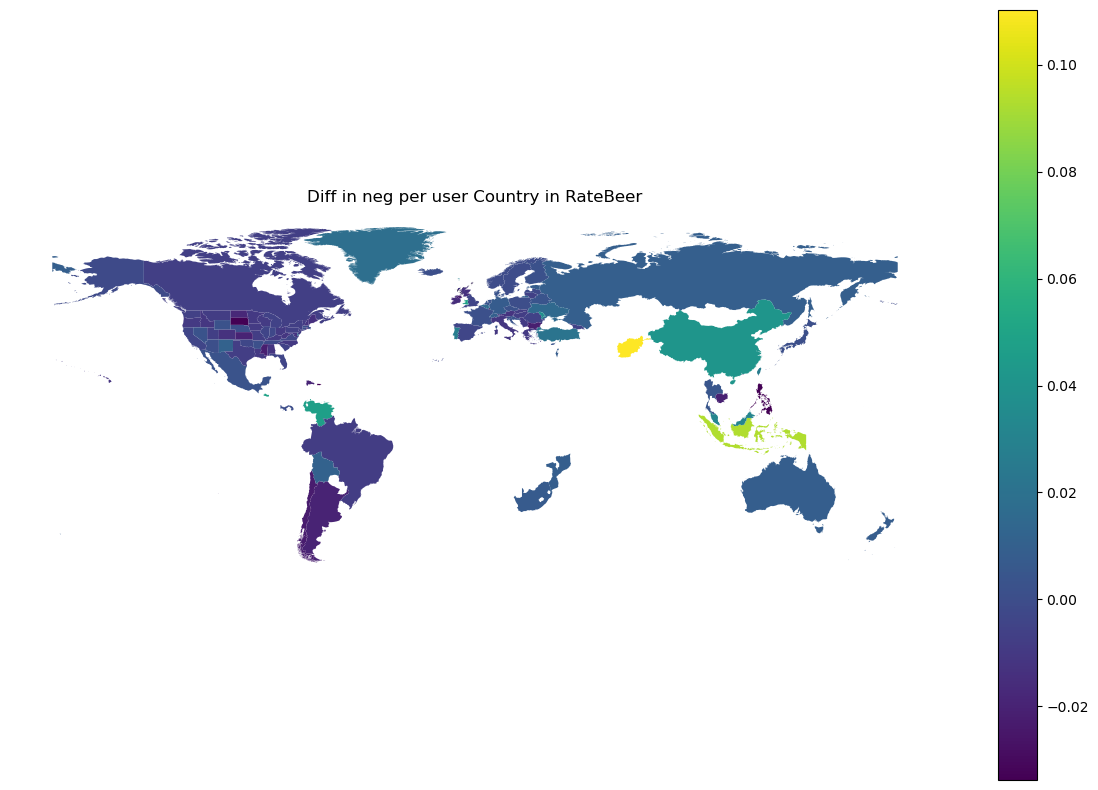

In [192]:

#display(df_comp)
plot_map(df_comp_pos_ba_M, shapefile, "Diff in pos per user", "BeerAdvocate", 'diff')
plot_map(df_comp_neg_ba_M, shapefile, "Diff in neg per user", "BeerAdvocate", 'diff')
plot_map(df_comp_pos_rb_M, shapefile, "Diff in pos per user", "RateBeer", 'diff')
plot_map(df_comp_rb_M, shapefile, "Diff in neg per user", "RateBeer", 'diff')

plot_map(df_comp_pos_ba_W, shapefile, "Diff in pos per user", "BeerAdvocate", 'diff')
plot_map(df_comp_neg_ba_W, shapefile, "Diff in neg per user", "BeerAdvocate", 'diff')
plot_map(df_comp_pos_rb_W, shapefile, "Diff in pos per user", "RateBeer", 'diff')
plot_map(df_comp_rb_W, shapefile, "Diff in neg per user", "RateBeer", 'diff')

We can observe that for the Millers brewery, compared to the median resentiment (in the BeerAdvisor):
It contains more positivity in the US and less positivity in the rest of the world
It contains more negativity in South America 

For RateBeer, the variation is quite high around the world.


We can observe that for the Weihenstephan brewery, compared to the median resentiment:
It contains more positivity around the world
It contains more negativity in Asia and the Balcans,but less negativity in the rest of the world
It contains more positivity in the US, followed by Europe and South-East-Asia, it contains less positivity in South America.
It contains more negativity in South-East-Asia, but less negativity in the rest of the world

check for the styles for the 2 breweries


In [193]:


# open as a dcitionary the file best_cat_per_user_location
with open('variables/best_cat_per_user_location.pickle', 'rb') as file:
    dictionary_data = pickle.load(file)

# transform the dictionary into a dataframe
df_best_cat = pd.DataFrame.from_dict(dictionary_data, orient='index')
df_best_cat.reset_index(inplace=True)
df_best_cat.rename({'index':'user_location', 0:'best_cat'}, inplace=True, axis=1)

locations = df_best_cat['user_location'].unique()

# Creating an empty DataFrame to store the results
new_df = pd.DataFrame({'user_location': locations})

# Iterating through each row to extract the top 3 styles with non-NaN values
for idx, row in df_best_cat.iterrows():
    # Extracting the non-NaN values for each row and sorting them by descending order
    non_nan_styles = row.drop('user_location').dropna().sort_values(ascending=False)
    
    # Selecting the top 3 styles (or less if there are fewer than 3)
    top_styles = non_nan_styles[:3]
    
    # Filling the corresponding columns in the new DataFrame
    new_df.loc[idx, 'Top1'] = top_styles.index[0] if len(top_styles) >= 1 else None
    new_df.loc[idx, 'Top2'] = top_styles.index[1] if len(top_styles) >= 2 else None
    new_df.loc[idx, 'Top3'] = top_styles.index[2] if len(top_styles) >= 3 else None

display(new_df)



,user_location,Top1,Top2,Top3
0,California,STOUTS,SOURS,PALE_ALES
1,Pennsylvania,STOUTS,SOURS,BELGIANS
2,Canada,STOUTS,BELGIANS,SOURS
3,Illinois,STOUTS,SOURS,PALE_ALES
4,New York,STOUTS,SOURS,BELGIANS
...,...,...,...,...
114,Marshall Islands,BROWNS,PORTERS,PALE_ALES
115,Slovenia,BELGIANS,BROWNS,PORTERS
116,El Salvador,BROWNS,BELGIANS,PORTERS
117,Dominican Republic,BROWNS,PORTERS,BELGIANS


In [194]:
# display all the styles of Miller Brewing Co. in BeerAdvocate
display(df_work_ba[df_work_ba['brewery_name'] == 'Miller Brewing Co.']['style'].unique())

# display all the styles of Anheuser-Bush in BeerAdvocate
display(df_work_ba[df_work_ba['brewery_name'] == 'Anheuser-Busch']['style'].unique())

# display all the styles of Weihenstephan in BeerAdvocate
display(df_work_ba[df_work_ba['brewery_name'] == 'Bayerische Staatsbrauerei Weihenstephan']['style'].unique())


array(['American Adjunct Lager', 'Herbed / Spiced Beer',
       'American Malt Liquor', 'Light Lager',
       'American Amber / Red Lager', 'American Amber / Red Ale',
       'American Blonde Ale', 'American Pale Wheat Ale',
       'Fruit / Vegetable Beer', 'Low Alcohol Beer'], dtype=object)

array(['American Amber / Red Lager', 'Fruit / Vegetable Beer',
       'Euro Pale Lager', 'Dunkelweizen', 'Irish Dry Stout',
       'German Pilsener', 'American Pale Lager', 'American Blonde Ale',
       'Herbed / Spiced Beer', 'Cream Ale', 'Doppelbock',
       'American Adjunct Lager', 'Light Lager', 'American Malt Liquor',
       'American Amber / Red Ale', 'Low Alcohol Beer',
       'Munich Helles Lager', 'American IPA', 'Pumpkin Ale',
       'American Double / Imperial Pilsner', 'Bock', 'Hefeweizen',
       'Black & Tan', 'Euro Dark Lager', 'American Pale Wheat Ale',
       'Irish Red Ale', 'Märzen / Oktoberfest', 'English Pale Ale',
       'American Porter', 'Winter Warmer', 'Oatmeal Stout',
       'American Pale Ale (APA)', 'Rye Beer', 'Witbier',
       'American Dark Wheat Ale', 'American Brown Ale', 'Czech Pilsener',
       'Kölsch'], dtype=object)

array(['Kellerbier / Zwickelbier', 'Hefeweizen', 'Märzen / Oktoberfest',
       'Low Alcohol Beer', 'Dunkelweizen', 'Maibock / Helles Bock',
       'Doppelbock', 'Kristalweizen', 'Weizenbock', 'Munich Helles Lager',
       'American Pale Ale (APA)', 'German Pilsener',
       'Munich Dunkel Lager', 'English Brown Ale'], dtype=object)

In [195]:
# create new df_miller_ba with the column user_location, style, neg, pos of every appearence of Miller Brewing Co. in brewery_name in df_work_ba 
df_miller_ba = df_work_ba[['user_location', 'style', 'neg', 'pos']][df_work_ba['brewery_name'] == 'Miller Brewing Co.']

display(df_miller_ba)
# load csv
df_styles_to_cat = pd.read_csv('../data/preprocessed/styles_to_categories.csv', sep=';')
display(df_styles_to_cat)

# in styles_to_cat change everything for strings, than replace all '_' by ' ' for all lines and the 9 fisrt columns
df_styles_to_cat = df_styles_to_cat.astype(str)
df_styles_to_cat = df_styles_to_cat.replace('_', ' ', regex=True)


# add category for each review
df_miller_ba['category'] = "nothing"
display(df_miller_ba)

# for each style in df_miller_ba, iterate through all the lines and the 9 first columns of df_styles_to_cat while the style is not found, and put the column name in category
for index, row in tqdm(df_miller_ba.iterrows(), total=len(df_miller_ba)):
    for col in df_styles_to_cat.columns[1:10]:
        if row['style'] in df_styles_to_cat[col].tolist():
            df_miller_ba.at[index, 'category'] = col




display(df_miller_ba)

# display all the categories of Miller Brewing Co. in BeerAdvocate
display(df_miller_ba['category'].unique())

#display the styles of categories == nothing
display(df_miller_ba[df_miller_ba['category'] == 'nothing']['style'].unique())

,user_location,style,neg,pos
435374,"United States, Iowa",American Adjunct Lager,0.045,0.249
435375,"United States, California",American Adjunct Lager,0.072,0.24
435376,"United States, Ohio",American Adjunct Lager,0.011,0.085
435377,"United States, Missouri",American Adjunct Lager,0.069,0.046
435378,"United States, Rhode Island",American Adjunct Lager,0.015,0.08
...,...,...,...,...
442206,"United States, Tennessee",Light Lager,0.055,0.084
442207,"United States, Virginia",Light Lager,0.216,0.104
442208,Canada,Light Lager,0.021,0.132
442209,"United States, Ohio",American Malt Liquor,0.049,0.131


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\3390544267.py:6: DtypeWarning: Columns (0,1,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_styles_to_cat = pd.read_csv('../data/preprocessed/styles_to_categories.csv', sep=';')


,PALE_ALES,BELGIANS,SOURS,WHEATS,BROWNS,PORTERS,STOUTS,LAGERS,OTHER,Column1,...,Column16366,Column16367,Column16368,Column16369,Column16370,Column16371,Column16372,Column16373,Column16374,Column16375
0,NaN,NaN,NaN,NaN,English_Brown_Ale,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,American_Double_Imperial_IPA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,Weizenbock,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,Russian_Imperial_Stout,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,American_IPA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saké_Honjozo,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saké_Nigori,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saké_Ginjo,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saké_Futsu_shu,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,user_location,style,neg,pos,category
435374,"United States, Iowa",American Adjunct Lager,0.045,0.249,nothing
435375,"United States, California",American Adjunct Lager,0.072,0.24,nothing
435376,"United States, Ohio",American Adjunct Lager,0.011,0.085,nothing
435377,"United States, Missouri",American Adjunct Lager,0.069,0.046,nothing
435378,"United States, Rhode Island",American Adjunct Lager,0.015,0.08,nothing
...,...,...,...,...,...
442206,"United States, Tennessee",Light Lager,0.055,0.084,nothing
442207,"United States, Virginia",Light Lager,0.216,0.104,nothing
442208,Canada,Light Lager,0.021,0.132,nothing
442209,"United States, Ohio",American Malt Liquor,0.049,0.131,nothing


100%|██████████| 6837/6837 [00:00<00:00, 8700.52it/s]


,user_location,style,neg,pos,category
435374,"United States, Iowa",American Adjunct Lager,0.045,0.249,LAGERS
435375,"United States, California",American Adjunct Lager,0.072,0.24,LAGERS
435376,"United States, Ohio",American Adjunct Lager,0.011,0.085,LAGERS
435377,"United States, Missouri",American Adjunct Lager,0.069,0.046,LAGERS
435378,"United States, Rhode Island",American Adjunct Lager,0.015,0.08,LAGERS
...,...,...,...,...,...
442206,"United States, Tennessee",Light Lager,0.055,0.084,LAGERS
442207,"United States, Virginia",Light Lager,0.216,0.104,LAGERS
442208,Canada,Light Lager,0.021,0.132,LAGERS
442209,"United States, Ohio",American Malt Liquor,0.049,0.131,OTHER


array(['LAGERS', 'nothing', 'OTHER', 'WHEATS'], dtype=object)

array(['Herbed / Spiced Beer', 'American Amber / Red Lager',
       'American Amber / Red Ale', 'American Blonde Ale',
       'Fruit / Vegetable Beer'], dtype=object)

Basic Explorations

NameError: name 'df_ba_new' is not defined

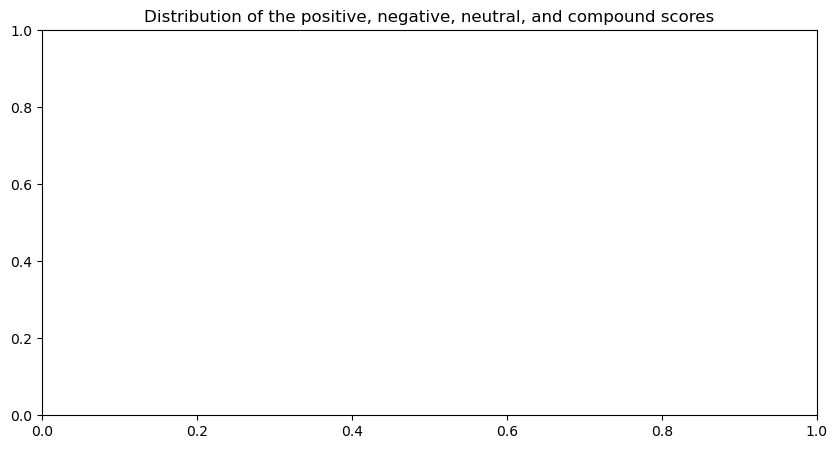

In [196]:
# plot the distribution of the positive, negative, neutral, and compound scores
plt.figure(figsize=(10, 5))
plt.title('Distribution of the positive, negative, neutral, and compound scores')

sns.histplot(data=df_ba_new, x='pos', label='positive', kde=True)
sns.histplot(data=df_ba_new, x='neg', label='negative', kde=True)
sns.histplot(data=df_ba_new, x='neu', label='neutral', kde=True)
sns.histplot(data=df_ba_new, x='compound', label='compound', kde=True)

plt.legend()
plt.show()



In [ ]:
b_rev = 'this is the worst beer I have ever tasted'
g_rev = 'this is the best beer I have ever tasted'
print(analyzer.polarity_scores(b_rev))
print(analyzer.polarity_scores(g_rev))


{'neg': 0.339, 'neu': 0.661, 'pos': 0.0, 'compound': -0.6249}
{'neg': 0.0, 'neu': 0.656, 'pos': 0.344, 'compound': 0.6369}
